In [9]:
from decifer import (
    HDF5Dataset,
    Tokenizer,
    UnconditionedDecifer,
    DeciferConfig,
    extract_prompt,
    load_model_from_checkpoint,
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop,
)

In [10]:
#model = UnconditionedDecifer(DeciferConfig())
device = 'cuda'
model = load_model_from_checkpoint('../uncon_trained_models/small_crystal500k/ckpt.pt', device)
model.to(device)
model.eval()
model.device = 'cuda'
dataset = HDF5Dataset('../data/crystallm/1k/hdf5/test_dataset.h5', data_to_load=['cif_tokenized'], block_size=10000)

number of total parameters: 25.36M


Processing datasets:   0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
model

UnconditionedDecifer(
  (transformer): ModuleDict(
    (wte): Embedding(372, 512)
    (wpe): Embedding(2048, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=False)
          (c_proj): Linear(in_features=2048, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=512, out_features=372, bias=False)
)

In [34]:
from time import time 

debug_max = 1
batch_size = 16
max_new_tokens = 500

In [35]:
start = time()
for i, sample in enumerate(dataset):
    if debug_max and (i+1) > debug_max:
        break
        
    prompt = extract_prompt(
        sample[0],
        model.device,
        add_composition=True,
        add_spacegroup=True
    ).unsqueeze(0)
    
    if prompt is not None:
        prompt = prompt.repeat(batch_size,1)
        ids = model.generate_batched_reps(prompt, max_new_tokens=max_new_tokens, disable_pbar=False)
#         print(ids)
print(time() - start)

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

9.310415267944336


In [36]:
start = time()
for i, sample in enumerate(dataset):
    if debug_max and (i+1) > debug_max:
        break
        
    prompt = extract_prompt(
        sample[0],
        model.device,
        add_composition=True,
        add_spacegroup=True
    ).unsqueeze(0)
    
    if prompt is not None:
        for j in range(batch_size):
            ids = model.generate(prompt, max_new_tokens=max_new_tokens, disable_pbar=False)
print(time() - start)

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/500 [00:00<?, ?it/s]

16.865593194961548


In [24]:
tok = Tokenizer()
decode = tok.decode
cifs = [decode(i[i != tok.padding_id].cpu().numpy()) for i in ids]

In [25]:
from pymatgen.io.cif import Structure, CifParser
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import matplotlib.pyplot as plt

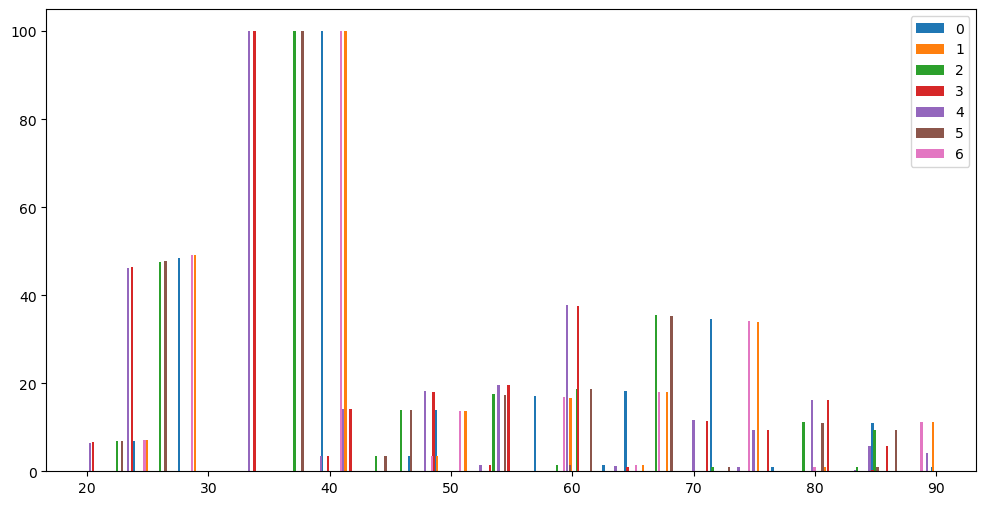

In [29]:
fig, ax = plt.subplots(figsize=(12,6))
new_cifs = []
for i,cif in enumerate(cifs):
    
    # Reinstate
    try:
        cif = replace_symmetry_loop_with_P1(cif)
        spacegroup_symbol = extract_space_group_symbol(cif)
        if spacegroup_symbol != "P 1":
            cif = reinstate_symmetry_loop(cif, spacegroup_symbol)

        new_cifs.append(cif)

        struct = CifParser.from_str(cif).get_structures()[0]
        
        # Init calculator object
        xrd_calc = XRDCalculator()

        # Get XRD pattern
        xrd_pattern = xrd_calc.get_pattern(struct)
        
        ax.bar(xrd_pattern.x, xrd_pattern.y, width=0.2, label=f'{i}')
    except Exception as e:
#         raise e
        continue
ax.legend()
plt.show()

In [30]:
for cif in cifs:
    print(cif, end='\n\n')

data_Li4Er8Ga4
_symmetry_space_group_name_H-M Fm-3m
_cell_length_a 6.4703
_cell_length_b 6.4703
_cell_length_c 6.4703
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 225
_chemical_formula_structural LiEr2Ga
_chemical_formula_sum 'Li4 Er8 Ga4'
_cell_volume 255.3348
_cell_formula_units_Z 4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1 'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Li Li0 4 0.0000 0.0000 0.0000 1.0000
Er Er1 8 0.2500 0.2500 0.2500 1.0000
Ga Ga2 4 0.0000 0.0000 0.5000 1.0000

data_Li4Er8Ga4
_symmetry_space_group_name_H-M Fm-3m
_cell_length_a 6.1820
_cell_length_b 6.1820
_cell_length_c 6.1820
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 225
_chemical_formula_structural LiEr2Ga
_chemical_formula_sum 'Li4 Er8 Ga4'
_cell_volume